# UNet_ResNet101

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-o8vazl6n
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-o8vazl6n
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301584 sha256=1d07072cab0f56e3b34a168282cf413f3907c52b24bf243b57038bc34c15bc31
  Stored in directory: /tmp/pip-ephem-wheel-cache-drddqt8k/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [2]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

In [3]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the dataset

In [5]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import clear_output

from skimage import color
from skimage import io

In [6]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 2
DATA_DIR = "/content/drive/MyDrive/Split1"
NUM_TRAIN_IMAGES = 502
NUM_VAL_IMAGES = 50
NUM_TEST_IMAGES = 126
#1-258
train_images = sorted(glob(os.path.join(DATA_DIR, "TrainSet_Raw/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "TrainSet_Masked/*")))[:NUM_TRAIN_IMAGES]
#259-294
val_images = sorted(glob(os.path.join(DATA_DIR, "TrainSet_Raw/*")))[NUM_TRAIN_IMAGES-NUM_VAL_IMAGES:NUM_TRAIN_IMAGES]
val_masks = sorted(glob(os.path.join(DATA_DIR, "TrainSet_Masked/*")))[NUM_TRAIN_IMAGES-NUM_VAL_IMAGES:NUM_TRAIN_IMAGES]
#295-368
test_images = sorted(glob(os.path.join(DATA_DIR, "TestSet_Raw/*")))[:NUM_TEST_IMAGES]
test_masks = sorted(glob(os.path.join(DATA_DIR, "TestSet_Masked/*")))[:NUM_TEST_IMAGES]


def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_jpeg(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 255
        #image = (image) / 255
        #image = image -1
        image = tf.math.round(image)

    else:
        image = tf.image.decode_jpeg(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset


train_images = data_generator(train_images, train_masks)
val_images = data_generator(val_images, val_masks)
test_images = data_generator(test_images, test_masks)


print("Train Dataset:", train_images)
print("Val Dataset:", val_images)
print("Test Dataset:", test_images)

Train Dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(512, 512, 1), dtype=tf.float32, name=None))>
Test Dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(512, 512, 1), dtype=tf.float32, name=None))>


In [7]:
TRAIN_LENGTH = 90
BATCH_SIZE = 4
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [8]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [9]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    #.map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = val_images.batch(BATCH_SIZE)
test_batches = test_images.batch(1)

In [10]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
for images, masks in train_batches.take(1):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

# UNet+ResNet101

In [12]:
base_model = tf.keras.applications.resnet.ResNet101(input_shape=[512, 512, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'conv1_relu',   # 256x256
    'conv2_block3_2_relu',   # 128x128
    'conv3_block4_2_relu',   # 64x63
    'conv4_block23_2_relu',  # 32x32
    'conv5_block3_3_conv',      # 16x16
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

171446536/171446536 [==============================] - 1s 0us/step


In [13]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [14]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[512, 512, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Train the model


In [15]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [17]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
show_predictions()

In [19]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
EPOCHS = 100
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 36//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches,
                          callbacks=[DisplayCallback()])

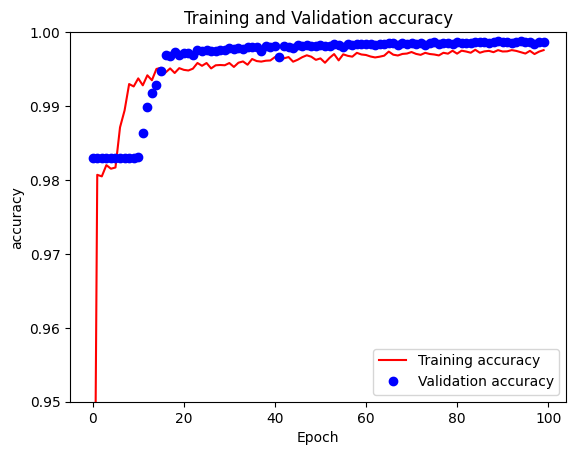

In [21]:
acc = model_history.history["accuracy"]
val_acc = model_history.history["val_accuracy"]

plt.figure()
plt.plot(model_history.epoch, acc, 'r', label='Training accuracy')
plt.plot(model_history.epoch, val_acc, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.ylim([0.95, 1])
plt.legend()
plt.show()

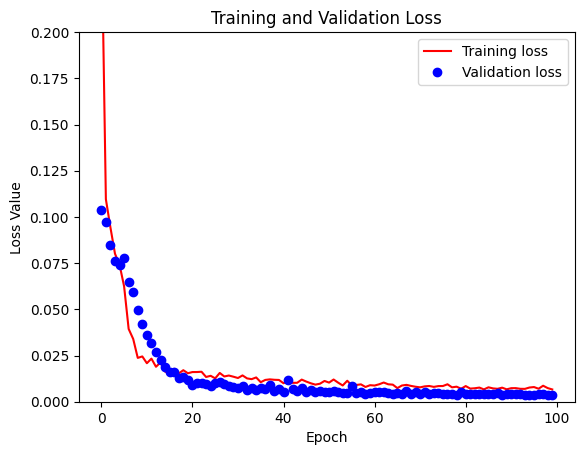

In [22]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.2])
plt.legend()
plt.show()

In [ ]:
res = 0

for image, mask in test_batches.take(126):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]

    m = tf.keras.metrics.MeanIoU(num_classes=2)
    m.update_state(pred_mask, mask)
    res += m.result().numpy()

res = res/126
print('MeanIoU:', res)

## Save Model

In [24]:
#import joblib

# Save the model as a pickle in a file
#joblib.dump(model, 'UNet_ResNet101_Two_Class_Split1.pkl')

In [25]:
#import pandas as pd

#pd.DataFrame.from_dict(model_history.history).to_csv('UNet_ResNet101_Two_Class_Split5_history.csv',index=False)

## Make predictions

In [26]:
def show_predictions_for_late(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      pred_mask = tf.argmax(pred_mask, axis=-1)
      pred_mask = pred_mask[..., tf.newaxis]
      display([image[0], mask[0], pred_mask[0]])

      m = tf.keras.metrics.MeanIoU(num_classes=2)
      m.update_state(pred_mask, mask)
      res = m.result().numpy()
      print('MeanIoU:',res)
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
im= show_predictions_for_late(test_batches,2)

## Download the output image

In [ ]:
from skimage import color
from skimage import io
import cv2 as cv

i=1
for image, mask in test_batches.take(126):
    pred_mask = model.predict(image) # (1, 512, 512, 3)
    pred_mask = tf.argmax(pred_mask, axis=-1) # TensorShape([1, 512, 512])
    pred_mask = pred_mask[..., tf.newaxis]

    fig = plt.figure(figsize=(15, 15),frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    #plt.imshow(tf.keras.utils.array_to_img(pred_mask[0]), cmap='gray')
    plt.axis('off')
    name='Predicted'+str(i)+'.png'
    plt.savefig(name)

    im = io.imread(name)
    name = '/content/drive/MyDrive/Split1/UNet_ResNet101_Predicted/'+name
    cv2.imwrite(name, im)
    i+=1